**Generative AI - Variational Autoencoder (VAE) for Face Generation**

**Author:** Rhishi Kumar Ayyappan

**Objective:** To build and train a Variational Autoencoder (VAE) from scratch to learn the latent distribution of human faces (CelebA dataset). The final model will be able to generate new, unique faces and interpolate between existing ones.

In [ ]:

# ==============================================================================
# SECTION 1: IMPORTS AND SETUP
# ==============================================================================
print("--- Section 1: Setup and Imports ---")

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

print(f"TensorFlow Version: {tf.__version__}")
print("Imports complete.")
print("\n" + "="*80 + "\n")


# ==============================================================================
# SECTION 2: CONSTANTS AND DATA PIPELINE
# ==============================================================================
print("--- Section 2: Constants and Data Pipeline ---")

# Define Constants
IMAGE_SIZE = 64
BATCH_SIZE = 128
LATENT_DIM = 100
EPOCHS = 20 # You can start with 20-30. More epochs = better faces.

# 1. Define Preprocessing Function
def preprocess(data):
    """
    Crops the center square of the CelebA image and resizes it,
    then normalizes to [0, 1].
    """
    image = data['image']
    # 1. Crop the center 178x178 square
    # Original shape is (218, 178, 3)
    image = tf.image.central_crop(image, central_fraction=178/218)

    # 2. Resize to 64x64
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])

    # 3. Normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # VAE input and output are the same
    return image, image

# 2. Load and Build the tf.data Pipeline
print("Loading CelebA dataset...")
# Use as_supervised=False to get the data as a dict
train_dataset, = tfds.load('celeb_a', split=['train'], as_supervised=False)

print("Building data pipeline...")
train_pipeline = (
    train_dataset
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1024) # Buffer size of 1024 batches
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Data pipeline built successfully.")

# 3. Visualize a sample batch to confirm it works
print("Visualizing a sample batch...")
sample_batch, _ = next(iter(train_pipeline))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_batch[i])
    plt.axis("off")
plt.suptitle("Sample Batch of 64x64 Cropped Faces")
plt.show()

print("\n" + "="*80 + "\n")


# ==============================================================================
# SECTION 3: VAE MODEL ARCHITECTURE
# ==============================================================================
print("--- Section 3: VAE Model Architecture ---")

# --- 1. The Sampling Layer (Reparameterization Trick) ---
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent vector."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# --- 2. The Encoder ---
def build_encoder(latent_dim=LATENT_DIM):
    """Builds the CNN Encoder."""
    encoder_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    # At this point, shape is (8, 8, 128)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)

    # Output layers for the distribution parameters
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Use the sampling layer
    z = Sampling()([z_mean, z_log_var])

    return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")


# --- 3. The Decoder ---
def build_decoder(latent_dim=LATENT_DIM):
    """Builds the 'De-convolutional' Decoder."""
    latent_inputs = keras.Input(shape=(latent_dim,))
    # Project up to a shape suitable for Conv2DTranspose
    # 8 * 8 * 128 = 8192
    x = layers.Dense(8 * 8 * 128, activation="relu")(latent_inputs)
    x = layers.Reshape((8, 8, 128))(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

    # Final layer to get back to 64x64x3
    # Use 'sigmoid' activation to output pixel values in [0, 1]
    decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)

    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

# --- Test the models ---
print("Building Encoder and Decoder...")
encoder = build_encoder()
decoder = build_decoder()

encoder.summary()
print("\n" + "="*60 + "\n")
decoder.summary()

print("\n" + "="*80 + "\n")


# ==============================================================================
# SECTION 4: CUSTOM VAE MODEL CLASS
# ==============================================================================
print("--- Section 4: Custom VAE Model Class ---")
"""
To handle the custom VAE loss, we subclass `keras.Model`.
This gives us full control over the `train_step`.

The VAE Loss Function: `total_loss = reconstruction_loss + kl_loss`

1.  Reconstruction Loss: How well did the decoder reconstruct the original image?
2.  Kullback-Leibler (KL) Divergence Loss: This is a regularization loss that
    forces the latent distribution to be close to a standard normal distribution.
"""

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Metrics to track
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]

    # Override call() for inference
    def call(self, inputs):
        _ , _, z = self.encoder(inputs)
        return self.decoder(z)

    # Override train_step for custom loss
    def train_step(self, data):
        # data is (x, y) from our pipeline, where x == y
        x, _ = data

        with tf.GradientTape() as tape:
            # 1. Get latent distribution and sample z
            z_mean, z_log_var, z = self.encoder(x)

            # 2. Decode z to reconstruct the image
            reconstruction = self.decoder(z)

            # 3. Calculate Losses
            # Reconstruction Loss (how well we rebuilt the image)
            # We sum over the image dimensions and take the mean over the batch
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
                )
            )

            # KL Divergence Loss (regularization)
            # Forces the latent distribution to be ~ N(0, 1)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Total Loss
            total_loss = recon_loss + kl_loss

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

print("VAE Model Class defined.")
print("\n" + "="*80 + "\n")


# ==============================================================================
# SECTION 5: TRAINING AND VISUALIZATION CALLBACK
# ==============================================================================
print("--- Section 5: Training and Visualization Callback ---")
"""
This custom Keras Callback will run at the end of every epoch,
generate a set of new faces by sampling random vectors,
and plot them in a grid to visually monitor progress.
"""

class ImageGeneratorCallback(keras.callbacks.Callback):
    def __init__(self, num_imgs=16, latent_dim=LATENT_DIM):
        self.num_imgs = num_imgs
        # Create persistent random vectors to see how they evolve
        self.random_vectors = tf.random.normal(shape=(num_imgs, latent_dim))

    def on_epoch_end(self, epoch, logs=None):
        print(f"\nGenerating images for epoch {epoch+1}...")
        # Use the decoder (which is part of our VAE model) to generate images
        generated_images = self.model.decoder(self.random_vectors)

        # Plot the images in a 4x4 grid
        grid_size = int(np.sqrt(self.num_imgs))
        plt.figure(figsize=(10, 10))
        for i in range(self.num_imgs):
            ax = plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(generated_images[i])
            plt.axis("off")
        plt.suptitle(f"Generated Faces at Epoch {epoch+1}")
        plt.show()

print("ImageGeneratorCallback defined.")
print("\n" + "="*80 + "\n")


# ==============================================================================
# SECTION 6: RUN THE TRAINING
# ==============================================================================
print("--- Section 6: Run the Training ---")
"""
We will train for 20 Epochs. On a free Colab T4 GPU, this should
take ~1-2 hours.
"""

print("Instantiating VAE model...")
vae = VAE(build_encoder(), build_decoder())

print("Compiling VAE model...")
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("Starting training...")
history = vae.fit(
    train_pipeline,
    epochs=EPOCHS,
    callbacks=[ImageGeneratorCallback(num_imgs=16, latent_dim=LATENT_DIM)]
)

print("Training complete.")
print("\n" + "="*80 + "\n")


# ==============================================================================
# SECTION 7: FINAL DELIVERABLES (THE "WOW" FACTOR)
# ==============================================================================
print("--- Section 7: Final Deliverables ---")

# --- 1. Plot Training History ---
print("Plotting training history...")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['recon_loss'], label='Reconstruction Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.title('KL Loss Over Epochs')
plt.legend()
plt.savefig('loss_curves.png')
plt.show()

# --- 2. Generate a Grid of New Faces ---
print("Generating final grid of new faces...")
num_new_faces = 25
random_vectors = tf.random.normal(shape=(num_new_faces, LATENT_DIM))
generated_images = vae.decoder(random_vectors)

plt.figure(figsize=(15, 15))
for i in range(num_new_faces):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.suptitle("Final Grid of Randomly Generated Faces")
plt.savefig('generated_faces.png')
plt.show()

# --- 3. Latent Space Interpolation (Morph) ---
print("Generating latent space interpolation...")

# Get two real images from our dataset
# We call next(iter()) again to get a fresh, random batch
sample_batch, _ = next(iter(train_pipeline))
image_a = sample_batch[0:1] # Keep batch dim
image_b = sample_batch[1:2] # Keep batch dim

# Get their latent representations (we only need the mean, z_mean)
z_mean_a, _, _ = vae.encoder(image_a)
z_mean_b, _, _ = vae.encoder(image_b)

# Number of steps to interpolate
num_steps = 10
interpolated_vectors = []

for t in np.linspace(0.0, 1.0, num_steps):
    # Linear interpolation (lerp)
    z_interpolated = z_mean_a * (1 - t) + z_mean_b * t
    interpolated_vectors.append(z_interpolated)

interpolated_vectors = tf.concat(interpolated_vectors, axis=0)
interpolated_images = vae.decoder(interpolated_vectors)

# Plot the interpolation
plt.figure(figsize=(20, 4))
for i in range(num_steps):
    ax = plt.subplot(1, num_steps, i + 1)
    plt.imshow(interpolated_images[i])
    plt.axis("off")
plt.suptitle("Latent Space Interpolation ('Morph')")
plt.savefig('interpolation.png')
plt.show()

print("\n" + "="*80 + "\n")




In [5]:
# ==============================================================================
# SECTION 8: SAVE MODEL WEIGHTS (CORRECTED)
# ==============================================================================
print("--- Section 8: Save Model Weights ---")

PROJECT_DIR = "vae_face_generation"
os.makedirs(PROJECT_DIR, exist_ok=True)

# The model needs to be built before saving weights
vae.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))


# FIX: Changed filenames to end in ".weights.h5" as required by Keras
print("Saving VAE weights...")
vae.save_weights(os.path.join(PROJECT_DIR, "vae.weights.h5"))

print("Saving Encoder weights...")
vae.encoder.save_weights(os.path.join(PROJECT_DIR, "encoder.weights.h5"))

print("Saving Decoder weights...")
vae.decoder.save_weights(os.path.join(PROJECT_DIR, "decoder.weights.h5"))

print(f"Model weights saved successfully in ./{PROJECT_DIR}/")
print("\n--- PROJECT COMPLETE ---")

--- Section 8: Save Model Weights ---
Saving VAE weights...
Saving Encoder weights...
Saving Decoder weights...
Model weights saved successfully in ./vae_face_generation/

--- PROJECT COMPLETE ---


--- Section 7: Re-generating Final Deliverables ---
Plotting training history...


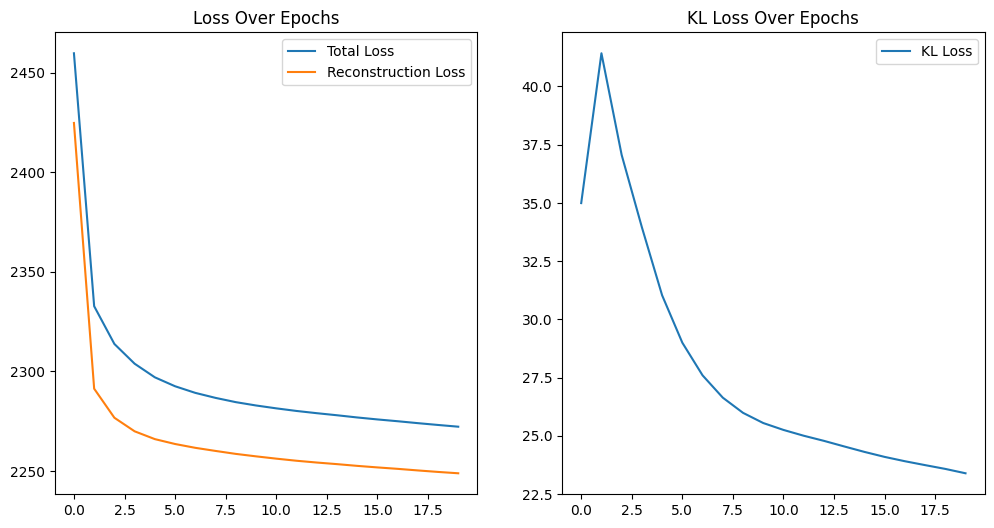

Generating final grid of new faces...


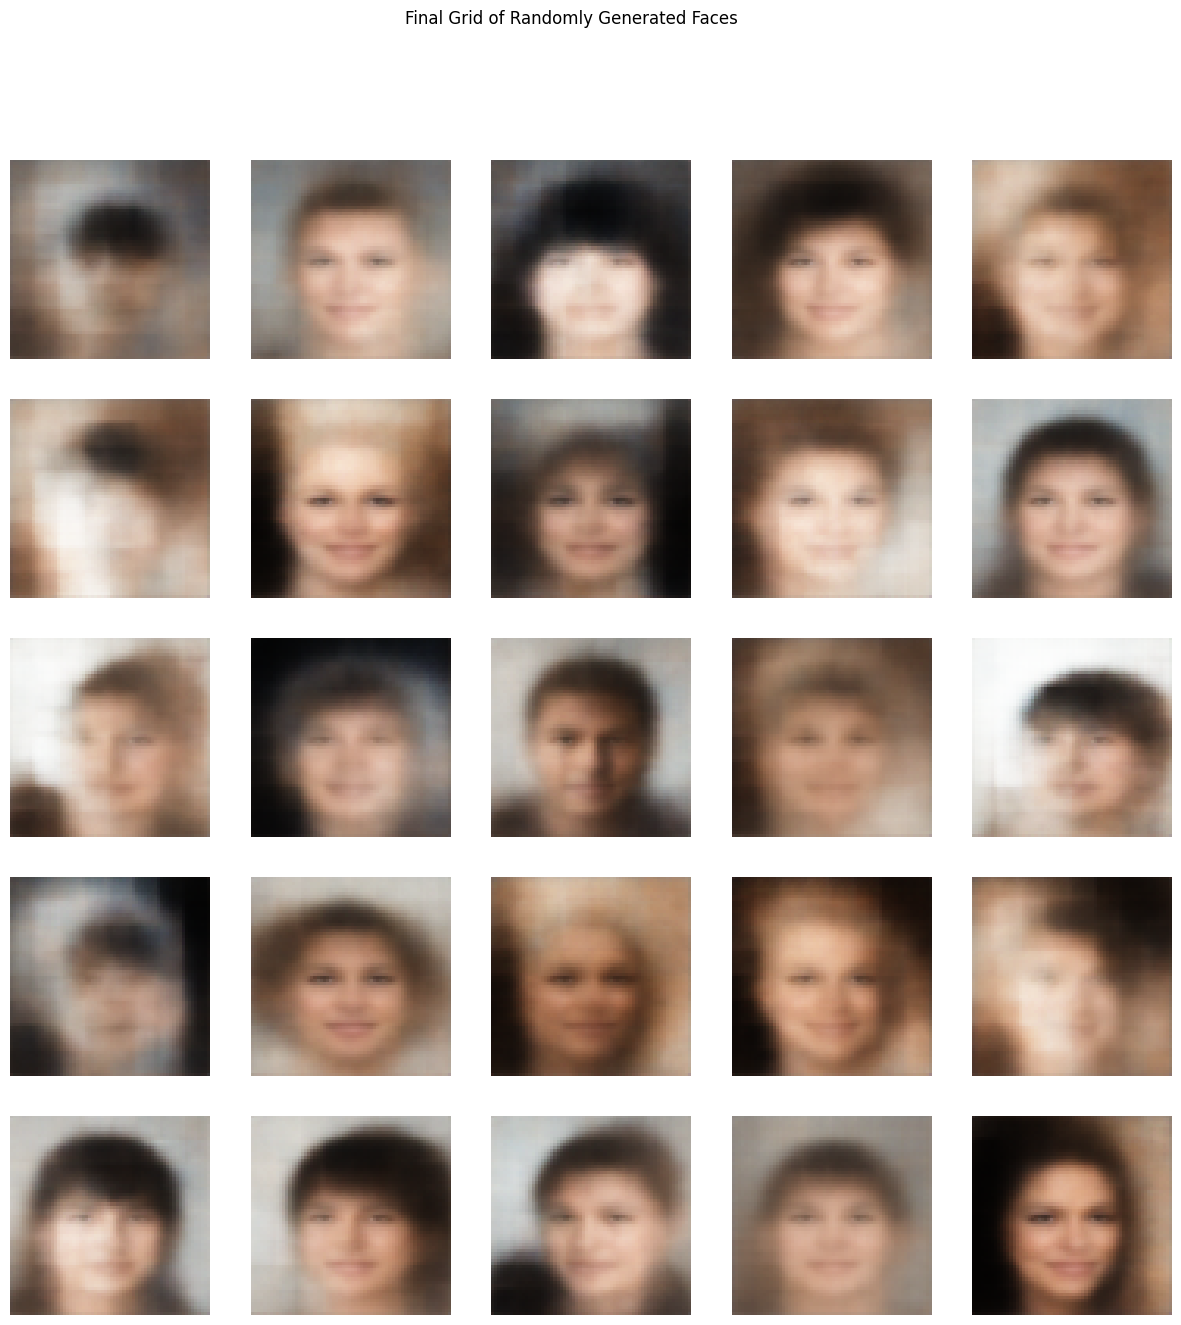

Generating latent space interpolation...


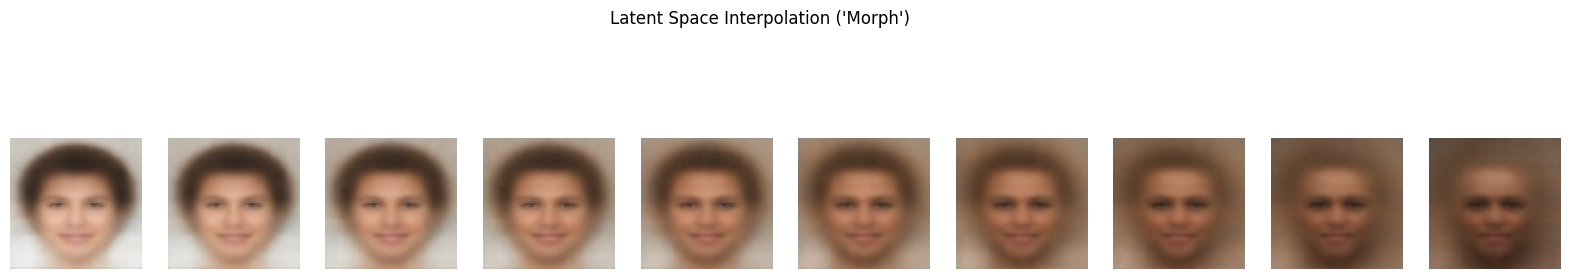



--- Section 8: Saving Model Weights ---
Saving VAE weights...
Saving Encoder weights...
Saving Decoder weights...
Model weights saved successfully in ./vae_face_generation/

--- FINAL OUTPUTS AND SAVING COMPLETE ---


In [6]:

# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

print("--- Section 7: Re-generating Final Deliverables ---")

# --- 1. Plot Training History ---
# The 'history' object from your training is still in memory
print("Plotting training history...")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['recon_loss'], label='Reconstruction Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.title('KL Loss Over Epochs')
plt.legend()
plt.savefig('loss_curves.png')
plt.show()

# --- 2. Generate a Grid of New Faces ---
# The 'vae' model and 'LATENT_DIM' are still in memory
print("Generating final grid of new faces...")
num_new_faces = 25
random_vectors = tf.random.normal(shape=(num_new_faces, LATENT_DIM))
generated_images = vae.decoder(random_vectors)

plt.figure(figsize=(15, 15))
for i in range(num_new_faces):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.suptitle("Final Grid of Randomly Generated Faces")
plt.savefig('generated_faces.png')
plt.show()

# --- 3. Latent Space Interpolation (Morph) ---
# The 'train_pipeline' is also still in memory
print("Generating latent space interpolation...")

sample_batch, _ = next(iter(train_pipeline))
image_a = sample_batch[0:1] # Keep batch dim
image_b = sample_batch[1:2] # Keep batch dim

z_mean_a, _, _ = vae.encoder(image_a)
z_mean_b, _, _ = vae.encoder(image_b)

num_steps = 10
interpolated_vectors = []

for t in np.linspace(0.0, 1.0, num_steps):
    z_interpolated = z_mean_a * (1 - t) + z_mean_b * t
    interpolated_vectors.append(z_interpolated)

interpolated_vectors = tf.concat(interpolated_vectors, axis=0)
interpolated_images = vae.decoder(interpolated_vectors)

plt.figure(figsize=(20, 4))
for i in range(num_steps):
    ax = plt.subplot(1, num_steps, i + 1)
    plt.imshow(interpolated_images[i])
    plt.axis("off")
plt.suptitle("Latent Space Interpolation ('Morph')")
plt.savefig('interpolation.png')
plt.show()

print("\n" + "="*80 + "\n")

# ==============================================================================
# SECTION 8: SAVE MODEL WEIGHTS (CORRECTED)
# ==============================================================================
print("--- Section 8: Saving Model Weights ---")

PROJECT_DIR = "vae_face_generation"
os.makedirs(PROJECT_DIR, exist_ok=True)

# FIX: Changed filenames to end in ".weights.h5" as required by Keras
print("Saving VAE weights...")
vae.save_weights(os.path.join(PROJECT_DIR, "vae.weights.h5"))

print("Saving Encoder weights...")
vae.encoder.save_weights(os.path.join(PROJECT_DIR, "encoder.weights.h5"))

print("Saving Decoder weights...")
vae.decoder.save_weights(os.path.join(PROJECT_DIR, "decoder.weights.h5"))

print(f"Model weights saved successfully in ./{PROJECT_DIR}/")
print("\n--- FINAL OUTPUTS AND SAVING COMPLETE ---")